# **Technical Challenge - Analista Sr. Applied Intelligence**
# Ejercicio 3
Sofía Cristina Aya Salazar

## 1. Importar Paquetes

In [1]:
# !pip install sklearn
# !pip install xgboost
# !pip install statsmodels
# !pip install ydata-profiling
# !pip install scikit-optimize

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from ydata_profiling import ProfileReport
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 2. Cargue de Datos

In [3]:
path = '/content/drive/MyDrive/Prueba MeLi/full_devices.csv'

data = pd.read_csv(path, encoding='latin-1')

# Se crea una copia para tener los datos sin modificaciones en el script
data_original = data.copy()

## 3. Vista inicial de los datos

In [4]:
print(f'Tamaño del dataset: {data.shape}')
data.head(5)

Tamaño del dataset: (124494, 12)


date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3

In [5]:
# Tipos de datos
data.dtypes

date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object

In [6]:
print(f"En total el dataset tiene datos para {data['date'].nunique()} días diferentes, entre {data['date'].min()} y {data['date'].max()}")

En total el dataset tiene datos para 304 días diferentes, entre 2015-01-01 y 2015-11-02


## 4. EDA

In [7]:
# En este caso se usa una librería existente para tener las visualizaciones requeridas en el EDA
ProfileReport(data_original)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Transformación de la fecha
data['date'] = pd.to_datetime(data['date'])
data.dtypes

date          datetime64[ns]
device                object
failure                int64
attribute1             int64
attribute2             int64
attribute3             int64
attribute4             int64
attribute5             int64
attribute6             int64
attribute7             int64
attribute8             int64
attribute9             int64
dtype: object

In [9]:
# Se ordenan los datos, para tenerlos desde la fecha más antigua a la más reciente
data = data.sort_values(by='date')
data.head(5)

date    device  failure  attribute1  attribute2  attribute3  \
0   2015-01-01  S1F01085        0   215630672          56           0   
779 2015-01-01  W1F0Y13C        0   234318640           0           0   
778 2015-01-01  W1F0XKWR        0    89660704           0           0   
777 2015-01-01  W1F0X7QX        0   162013456           0           0   
776 2015-01-01  W1F0X7PR        0    13138392           0           0   

     attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0            52           6      407438           0           0           7  
779           0           4      185772           0           0           3  
778           0           7          30           0           0           0  
777           0          12      217686           0           0           0  
776           0           9      191343           0           0           0

In [10]:
# Se elimina el duplicado
data = data.drop_duplicates()
data.shape

(124493, 12)

In [11]:
# Análisis de la variable Y
display(data['failure'].value_counts())
display(data['failure'].value_counts(normalize=True)*100)

failure
0    124387
1       106
Name: count, dtype: int64

failure
0    99.914855
1     0.085145
Name: proportion, dtype: float64

De la celda anterior es posible notar que hay desequilibrio entre las clases, ya que menos del 1% de los registros presentaron falla. Por lo tanto, ahora se agregarán visualizaciones para entender mejor el comportamiento de los datos

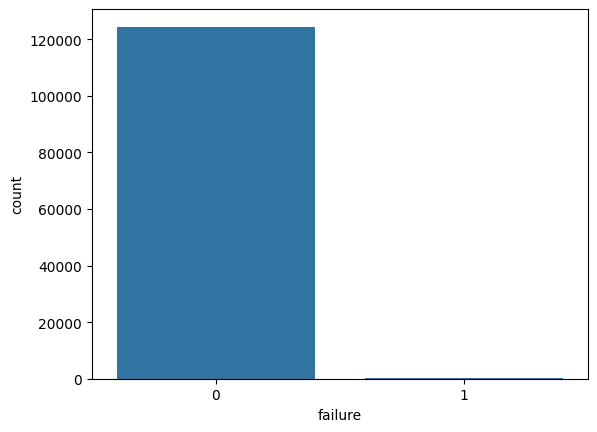

In [12]:
sns.countplot(x='failure', data=data)
plt.show()

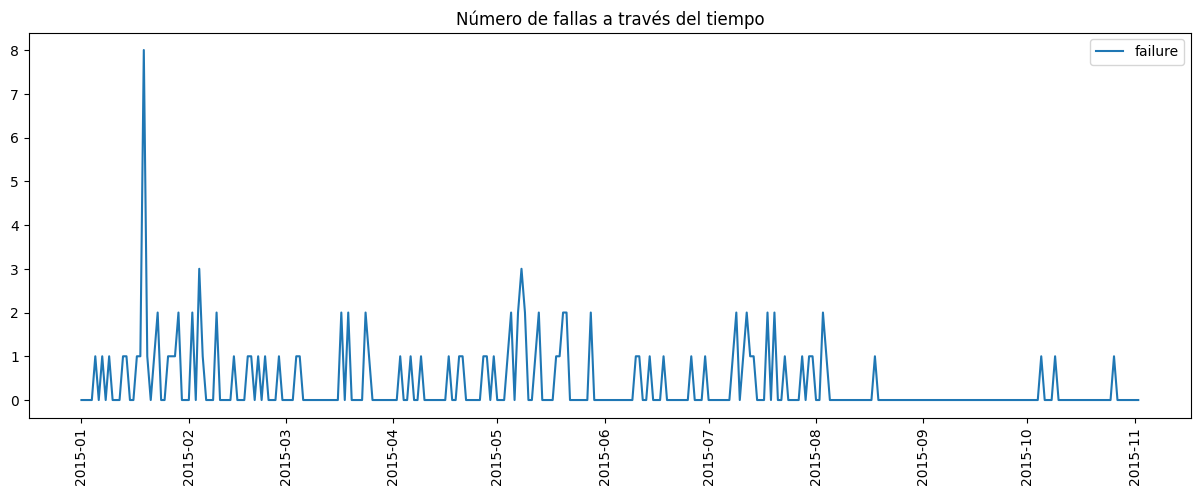

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(data.groupby('date')['failure'].sum(), label='failure')
plt.title('Número de fallas a través del tiempo')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [14]:
# Deep dive en la variable 'device' para determinar si es relevante en el modelo
device_counts = data['device'].value_counts()
device_failures = data[data['failure'] == 1]['device'].value_counts()
failure_rate_per_device = (device_failures / device_counts) * 100

device_failure_rates = pd.DataFrame({'Total_Observations': device_counts,
                                     'Total_Failures': device_failures,
                                     'Failure_Rate (%)': failure_rate_per_device}).fillna(0)

device_failure_rates

Total_Observations  Total_Failures  Failure_Rate (%)
device                                                        
S1F01085                   6             0.0               0.0
S1F013BB                   6             0.0               0.0
S1F0166B                   6             0.0               0.0
S1F01E6Y                  48             0.0               0.0
S1F01JE0                   6             0.0               0.0
...                      ...             ...               ...
Z1F1VMZB                 292             0.0               0.0
Z1F1VQFY                 125             1.0               0.8
Z1F26YZB                  84             0.0               0.0
Z1F282ZV                  84             0.0               0.0
Z1F2PBHX                  83             0.0               0.0

[1169 rows x 3 columns]

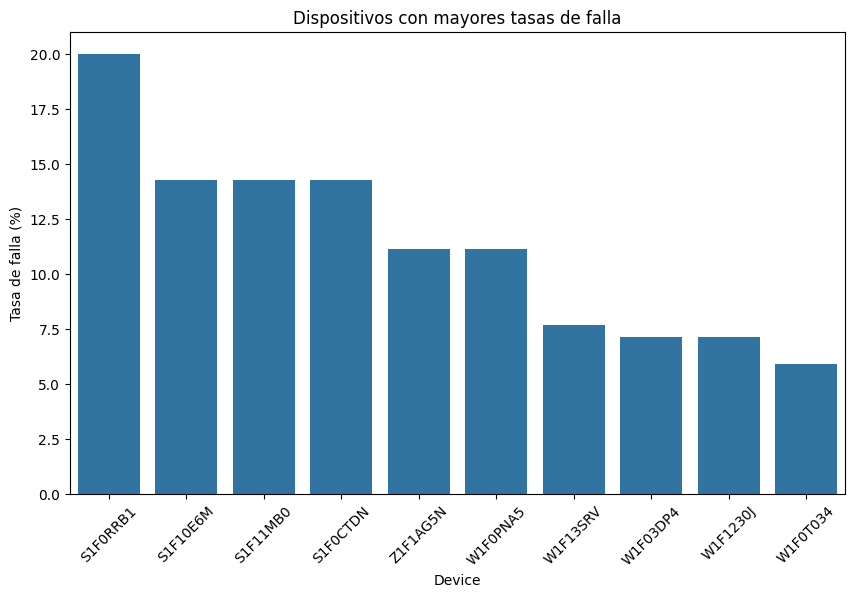

In [15]:
# Gráfica de los dispositivos con mayores tasas de falla
plt.figure(figsize=(10,6))
sns.barplot(x=device_failure_rates.sort_values('Failure_Rate (%)', ascending=False).head(10).index, y='Failure_Rate (%)',
            data=device_failure_rates.sort_values('Failure_Rate (%)', ascending=False).head(10))
plt.title('Dispositivos con mayores tasas de falla')
plt.xlabel('Device')
plt.ylabel('Tasa de falla (%)')
plt.xticks(rotation=45)
plt.show()

Si bien se observa que hay diferencias en las fallas dependiendo del dispositivo, debido a la gran cantidad de niveles (valores únicos de la variable) se decide no hacer ni Label Encoding ni One-Hot Encoding. Por tal motivo, se toma la decisión de no incluirla dentro de los features

In [16]:
data = data.drop(columns=['device'])

## 5. Serie de tiempo

En primer lugar se construirá un modelo ARIMA para capturar los patrones lineales o las dependencias temporales que haya en la data

date
2015-01-01    0
2015-01-02    0
2015-01-03    0
2015-01-04    0
2015-01-05    1
             ..
2015-10-29    0
2015-10-30    0
2015-10-31    0
2015-11-01    0
2015-11-02    0
Freq: D, Name: failure, Length: 306, dtype: int64

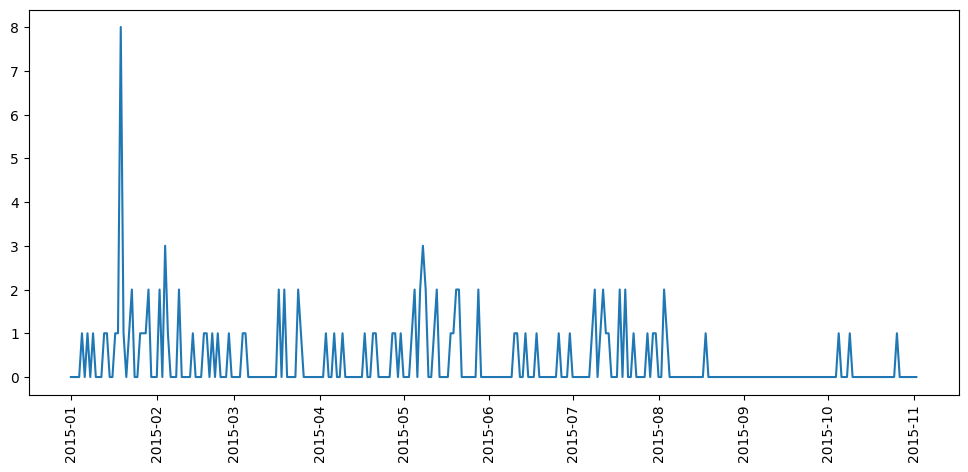

In [17]:
# Lo primero es organizar los datos de la forma en que se necesitan. Se toma la fecha como el índice,
# haciéndolo un df de serie de tiempo. Igualmente, se especifica la variable Y ('failure') y la
# frecuencia diaria ('D') de los registros
failures_series = data.set_index('date')['failure'].resample('D').sum().fillna(0)
display(failures_series)

plt.figure(figsize=(12, 5))
plt.plot(failures_series)
plt.xticks(rotation='vertical')
plt.show()

Ahora se va a revisar la estacionariedad (media, vaianza, autocorrelación constante en el tiempo) de la serie para poder proseguir con el modelo. Sin revisar este supuesto, se pueden generar pronósticos errados

In [18]:
# Se hace la prueba de Dickey-Fuller para ver si la serie ya sea estacionaria
result_adf = adfuller(failures_series)

print('Prueba ADF - Serie Original')
print('Estadístico ADF:', result_adf[0])
print(f'P-Value: {result_adf[1]: .3f}')
print('Valores críticos:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value:.3f}')

Prueba ADF - Serie Original
Estadístico ADF: -14.628112798505416
P-Value:  0.000
Valores críticos:
	1%: -3.452
	5%: -2.871
	10%: -2.572


Dado que en Dickey-Fuller la H0 es que la serie no es estacionaria y en este caso se tiene un p-value de 0, se rechaza la hipótesis nula y se concluye que la serie sí es estacionaria

In [19]:
# # No es necesario diferenciar la serie para hacerla estacionaria
# failures_series_diff = failures_series.diff().dropna()
# display(failures_series_diff)

# plt.figure(figsize=(12, 5))
# plt.plot(failures_series_diff)
# plt.xticks(rotation='vertical')
# plt.show()

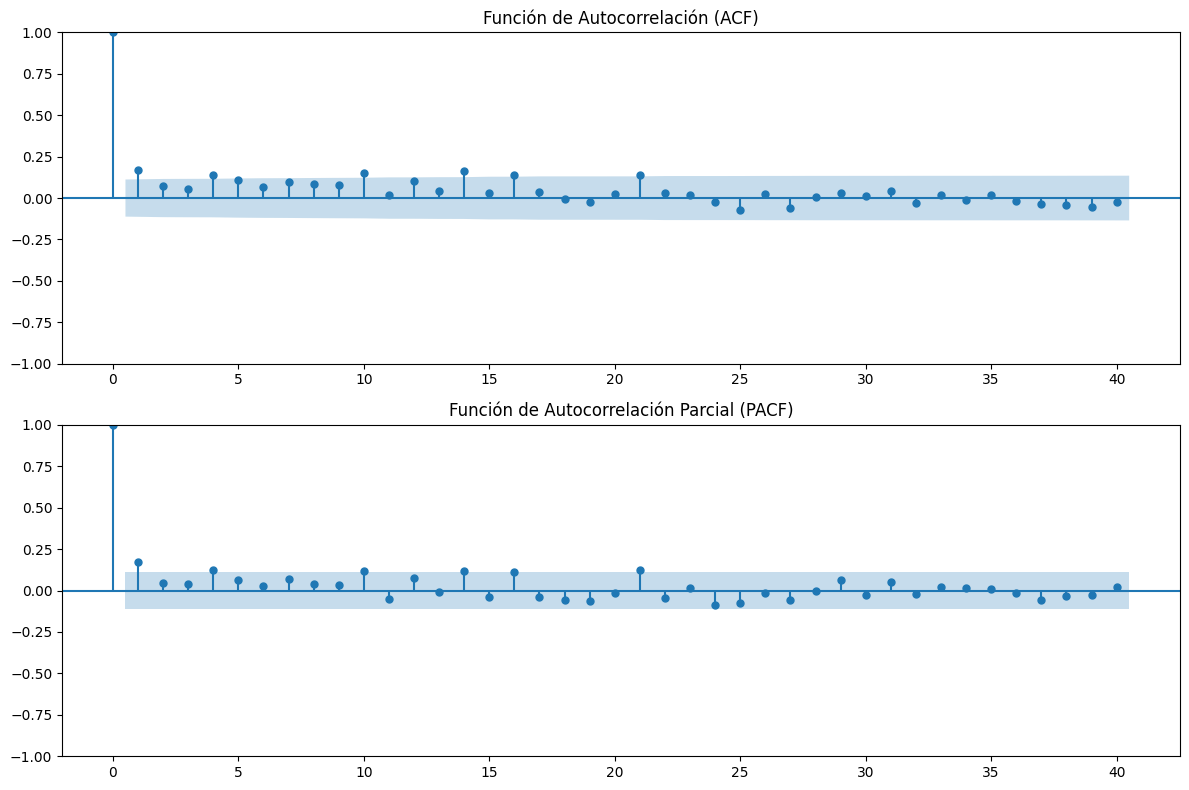

In [20]:
# Ahora se graficará el autocorrelograma para definir los parámetros del modelo
fig, ax = plt.subplots(2, 1, figsize=(12,8))

plot_acf(failures_series, ax=ax[0], lags=40)
ax[0].set_title('Función de Autocorrelación (ACF)')

plot_pacf(failures_series, ax=ax[1], lags=40, method='ywm')
ax[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [21]:
# Seleccionar órdenes p, d, q usando ACF y PACF (aquí asumimos valores)
p_rango = [1, 4] # Orden autorregresivo - PACF
d_rango = [0, 1] # No se diferenció
q_rango = [1, 4] # Orden de media móvil - ACF

# Se hace la prueba con diferentes valores, ya que no es claro si es (1,0,1) o (4,0,1) o (4,0,4) o cuál
def evaluate_arima_model(series, arima_order):
    try:
        model = ARIMA(series, order=arima_order)
        model_fit = model.fit()

        aic = model_fit.aic
        bic = model_fit.bic
        return aic, bic, model_fit

    except:
        return None, None, None

results = []
for p in p_rango:
    for d in d_rango:
        for q in q_rango:
            order = (p, d, q)
            aic, bic, model_fit = evaluate_arima_model(failures_series, order)

            if aic is not None:
                results.append({'order': order, 'aic': aic, 'bic': bic, 'model_fit': model_fit})
                print(f'ARIMA{order} - AIC:{aic:.2f} BIC:{bic:.2f}')

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('aic')
print('\nMejores modelos según AIC:')
print(results_df.head())

ARIMA(1, 0, 1) - AIC:688.71 BIC:703.60
ARIMA(1, 0, 4) - AIC:691.28 BIC:717.35
ARIMA(1, 1, 1) - AIC:689.31 BIC:700.47
ARIMA(1, 1, 4) - AIC:694.38 BIC:716.70
ARIMA(4, 0, 1) - AIC:691.59 BIC:717.66


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 4) - AIC:694.72 BIC:731.96
ARIMA(4, 1, 1) - AIC:693.21 BIC:715.53
ARIMA(4, 1, 4) - AIC:699.39 BIC:732.87

Mejores modelos según AIC:
       order         aic         bic  \
0  (1, 0, 1)  688.709177  703.603517   
2  (1, 1, 1)  689.308636  700.469571   
1  (1, 0, 4)  691.283134  717.348230   
4  (4, 0, 1)  691.591460  717.656555   
6  (4, 1, 1)  693.208620  715.530490   

                                           model_fit  
0  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
2  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
1  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
6  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Con base en los resultados, el mejor modelo es un ARIMA(1, 0, 1), así que se procederá a hacer el pronóstico de la siguiente semana para ver qué resultados se obtienen

In [22]:
mejor_modelo = results_df.iloc[0]
arima_result = mejor_modelo['model_fit']
print(arima_result.summary())

# Pronóstico
forecast = arima_result.forecast(steps=7)
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                failure   No. Observations:                  306
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -340.355
Date:                Fri, 06 Dec 2024   AIC                            688.709
Time:                        04:01:06   BIC                            703.604
Sample:                    01-01-2015   HQIC                           694.666
                         - 11-02-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3380      0.162      2.080      0.037       0.020       0.656
ar.L1          0.9421      0.050     18.904      0.000       0.844       1.040
ma.L1         -0.8623      0.069    -12.506      0.0

Se puede notar que los valores del 3 al 9 de noviembre van aumentando. Esto quiere decir que la probabilidad de falla aumenta con el pasar de los días

Sin embargo, lo que realmente se desea es tener las predicciones dentro de la muestra de datos que posteriormente se usará para construir un modelo de ML. De esta forma, se incluye adecuadamente el efecto temporal en la predicción

In [23]:
# Predicciones en la muestra
df_arima_pred = arima_result.predict(start=failures_series.index[0], end=failures_series.index[-1])
df_arima_pred = df_arima_pred.rename('arima_pred').to_frame()
df_arima_pred.index = pd.to_datetime(df_arima_pred.index)
df_arima_pred

arima_pred
date                  
2015-01-01    0.337993
2015-01-02    0.295357
2015-01-03    0.264463
2015-01-04    0.241273
2015-01-05    0.223399
...                ...
2015-10-29    0.208828
2015-10-30    0.199627
2015-10-31    0.191694
2015-11-01    0.184854
2015-11-02    0.178955

[306 rows x 1 columns]

Ahora que se tienen las predicciones del ARIMA(1,0,1) para cada una de las fechas, se debe hacer el join con el dataset original:

In [24]:
df_merged = data.copy()

# Unir las predicciones de ARIMA con el df
df_merged = df_merged.set_index('date')
df_merged = df_merged.join(df_arima_pred, how= 'left')
df_merged['arima_pred'] = df_merged['arima_pred'].fillna(method='ffill')
df_merged

<ipython-input-24-248d17d70ce7>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['arima_pred'] = df_merged['arima_pred'].fillna(method='ffill')


failure  attribute1  attribute2  attribute3  attribute4  \
date                                                                  
2015-01-01        0   215630672          56           0          52   
2015-01-01        0   234318640           0           0           0   
2015-01-01        0    89660704           0           0           0   
2015-01-01        0   162013456           0           0           0   
2015-01-01        0    13138392           0           0           0   
...             ...         ...         ...         ...         ...   
2015-11-02        0   159867281           0           0          13   
2015-11-02        0   205465736           0           0          12   
2015-11-02        0   226953408           0           0           0   
2015-11-02        0   128174672           0           1           6   
2015-11-02        0    17572840           0           0           0   

            attribute5  attribute6  attribute7  attribute8  attribute9  \
date                                                                     
2015-01-01           6      407438           0           0           7   
2015-01-01           4      185772           0           0           3   
2015-01-01           7          30           0           0           0   
2015-01-01          12      217686           0           0           0   
2015-01-01           9      191343           0           0           0   
...                ...         ...         ...         ...         ...   
2015-11-02          11      347165          32          32           0   
2015-11-02          11      353337           0           0           0   
2015-11-02          12      358980           0           0           0   
2015-11-02          15      356320           0           0           1   
2015-11-02          10      351431           0           0           0   

            arima_pred  
date                    
2015-01-01    0.337993  
2015-01-01    0.337993  
2015-01-01    0.337993  
2015-01-01    0.337993  
2015-01-01    0.337993  
...                ...  
2015-11-02    0.178955  
2015-11-02    0.178955  
2015-11-02    0.178955  
2015-11-02    0.178955  
2015-11-02    0.178955  

[124493 rows x 11 columns]

**NOTA:** debido a que el objetivo de la prueba es predecir la probabilidad de falla un día antes, es necesario mover las predicciones del ARIMA:

In [25]:
df_merged['arima_pred_shifted'] = df_merged['arima_pred'].shift(1)
df_merged = df_merged.dropna(subset=['arima_pred_shifted'])
df_merged

failure  attribute1  attribute2  attribute3  attribute4  \
date                                                                  
2015-01-01        0   234318640           0           0           0   
2015-01-01        0    89660704           0           0           0   
2015-01-01        0   162013456           0           0           0   
2015-01-01        0    13138392           0           0           0   
2015-01-01        0    33224832           0           0           0   
...             ...         ...         ...         ...         ...   
2015-11-02        0   159867281           0           0          13   
2015-11-02        0   205465736           0           0          12   
2015-11-02        0   226953408           0           0           0   
2015-11-02        0   128174672           0           1           6   
2015-11-02        0    17572840           0           0           0   

            attribute5  attribute6  attribute7  attribute8  attribute9  \
date                                                                     
2015-01-01           4      185772           0           0           3   
2015-01-01           7          30           0           0           0   
2015-01-01          12      217686           0           0           0   
2015-01-01           9      191343           0           0           0   
2015-01-01          13      216960           0           0           0   
...                ...         ...         ...         ...         ...   
2015-11-02          11      347165          32          32           0   
2015-11-02          11      353337           0           0           0   
2015-11-02          12      358980           0           0           0   
2015-11-02          15      356320           0           0           1   
2015-11-02          10      351431           0           0           0   

            arima_pred  arima_pred_shifted  
date                                        
2015-01-01    0.337993            0.337993  
2015-01-01    0.337993            0.337993  
2015-01-01    0.337993            0.337993  
2015-01-01    0.337993            0.337993  
2015-01-01    0.337993            0.337993  
...                ...                 ...  
2015-11-02    0.178955            0.178955  
2015-11-02    0.178955            0.178955  
2015-11-02    0.178955            0.178955  
2015-11-02    0.178955            0.178955  
2015-11-02    0.178955            0.178955  

[124492 rows x 12 columns]

## 6. Tratamiento de datos

Dado el desequilibrio entre las clases, se decide utilizar la técnica SMOTE para aumentar la cantidad de casos del nivel minoritario (falla) en el dataset

In [26]:
# Lo primero es hacer la división de los features y la variable a predecir
x = df_merged.drop(['failure', 'arima_pred'], axis=1)
y = df_merged['failure']

# Distribución de la variable Y
display(y.value_counts())
display(y.value_counts(normalize=True)*100)

# Split del dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1832)

# SMOTE en el conjunto de entrenamiento
smote = SMOTE(random_state= 1832)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Nueva distribución de la variable Y
display(y_train_resampled.value_counts())
display(y_train_resampled.value_counts(normalize=True)*100)

failure
0    124386
1       106
Name: count, dtype: int64

failure
0    99.914854
1     0.085146
Name: proportion, dtype: float64

failure
0    99508
1    99508
Name: count, dtype: int64

failure
0    50.0
1    50.0
Name: proportion, dtype: float64

In [27]:
# Check NA
y_train_resampled.isna().sum()

0

Ahora que se tienen clases balanceadas, se puede seguir con el tratamiento de los features. El siguiente paso será hacer una normalización estándar de las variables, de forma que la escala de los features no afecte

In [28]:
# Escalado de características
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)

## 7. Modelo XGBoost

Ahora que se incluyó el efecto de la temporalidad en el dataset de las fallas de máquinas, se procede a hacer el modelo de clasificación que prediga la probabilidad. Se tomó la decisión de usar XGBoost

In [29]:
# Definir el espacio de búsqueda
search_spaces = {'n_estimators': Integer(50, 500), 'max_depth': Integer(2, 20),
                 'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                 'scale_pos_weight': Real(1, 10)}

xgb_clf = xgb.XGBClassifier(random_state= 1832, use_label_encoder= False, eval_metric='logloss')

# Validación cruzada
skf = StratifiedKFold(n_splits= 5)

bayes_search = BayesSearchCV(estimator= xgb_clf, search_spaces= search_spaces, scoring= 'roc_auc',
                             cv= skf, n_iter= 30, n_jobs= -1, random_state= 1832, verbose= 1)

bayes_search.fit(x_train_scaled, y_train_resampled)
best_params = bayes_search.best_params_
print(f"\nMejores hiperparámetros encontrados: {best_params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_xgb = xgb.XGBClassifier(**best_params, random_state= 1832, use_label_encoder= False, eval_metric= 'logloss')

best_xgb.fit(x_train_scaled, y_train_resampled)
y_pred = best_xgb.predict(x_test_scaled)
y_probs = best_xgb.predict_proba(x_test_scaled)[:,1]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Mejores hiperparámetros encontrados: OrderedDict([('learning_rate', 0.1275612987144888), ('max_depth', 18), ('n_estimators', 276), ('scale_pos_weight', 9.354738107337244)])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:07:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Matriz de confusión


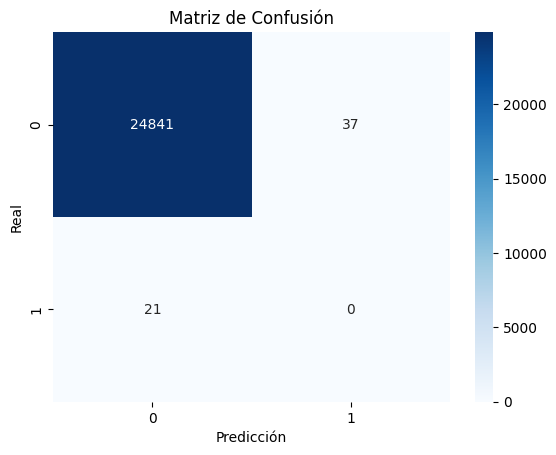

In [30]:
print("Matriz de confusión")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [31]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.00      0.00      0.00        21

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



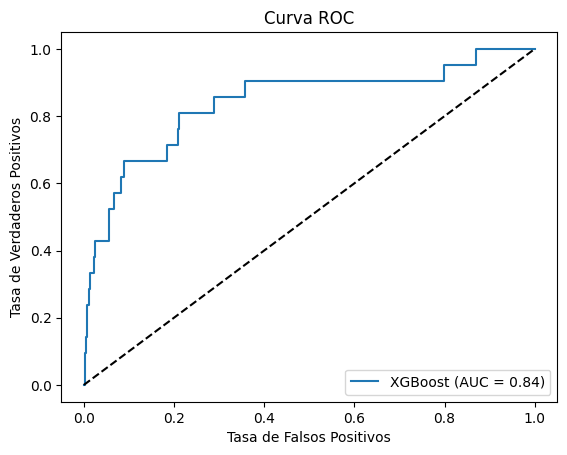

In [32]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], 'k--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

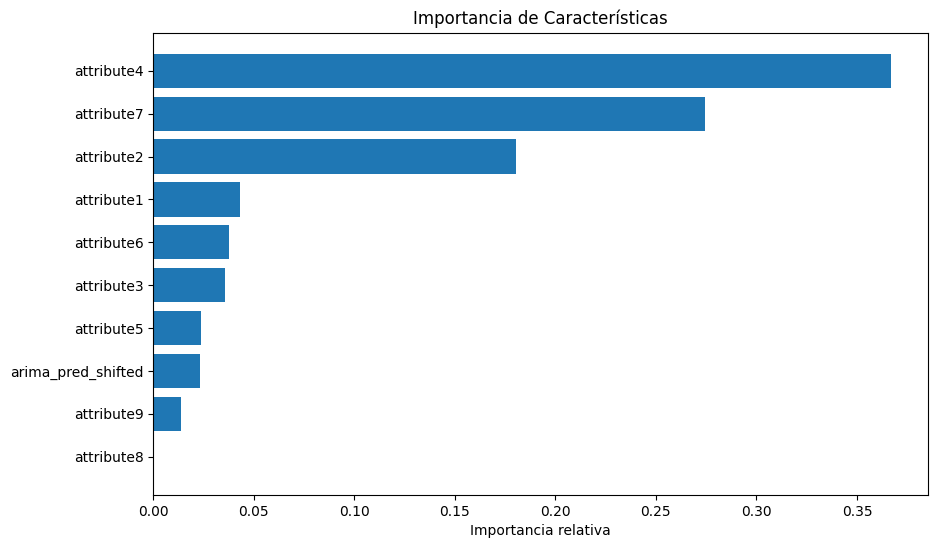

In [33]:
# Importancia de las variables
importances = best_xgb.feature_importances_
feature_names = x.columns
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Importancia de Características')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importancia relativa')
plt.show()

## 8. Conclusiones

Del ejercicio anterior se pueden encontrar diversos insights y conclusiones:
* En primer lugar, se observa que el modelo en la clase 1 (falla) no predice adecuadamente (ver matriz de confusión). Si bien es cierto que el AUC tiene un buen desempeño y la curva ROC se ve bien en términos generales, esto se debe a una alta exactitud por la clase mayoritaria (0) pero sin reconocer en realidad bien la clase minoritaria (<1% de los registros)
* Puesto que el objetivo es predecir las fallas antes de que ocurran, el modelo en sí no ofrece valor ya que no se ajusta adecuadamente

Para mejorar el modelo se podría hacer una serie de experimentos que incluyan:
* Recopilar más datos para la clase minoritaria, ya que aunque se utilizó SMOTE para balancear la muestra, la realidad es que es un dataset demasiado desequilibrado
  * Igualmente, se podrían aplicara otros métodos que ayuden con la generación de datos sintéticos para balancear la muestra
* Ajustar el umbral que se usa para determinar las clases. Si bien por default se tiene 0.5, quizá este valor es demasiado alto en el contexto de estos datos. Reducirlo podría ayudar con la correcta predicción de la clase positiva, a costa -por supuesto- de sacrificar precisión
* Si bien en esta ocasión se tomó la decisión de no incluir la variable 'device' por su alta cardinalidad, en realidad puede ser un feature que aporte al modelo en caso de que los dispositivos presenten una frecuencia de fallas diferente. Por lo tanto, una primer mejora está en la opción de incluirla al momento de modelar (con el respectivo tratamiento)
* Así mismo, relacionado con el feature selection, en el EDA se observó que los atributos 7 y 8 están altamente correlacionados y ambos tienen una gran presencia de ceros. Una buena práctica (especialmente si se usan modelos sensibles a la multicolinealidad) sería dejar solo uno, apoyado en el conocimiento del negocio y qué representa cada uno. En el caso de algoritmos con árboles de decisión, estos suelen manejar adecuadamente este problema al seleccionar solo uno de los redundantes (como ocurrió en este caso, que el atributo 8 tiene una importancia de ~0 como se observa en la gráfica), por lo que no es algo que explique el rendimiento del modelo en esta situación
* Probar con una calibración de hiperparámetros diferente. Aquí se usó optimización bayesiana ya que es más eficiente que el grid-search, sin embargo, es posible que el espacio escogido para probar los parámetros tenga espacio para mejorar
* Igualmente, podría probarse con otros modelos para la predicción , como un RandomForestClassifier, LightGBM o CatBoost. Así mismo, se podrían evaluar alternativas para darle un mejor tratamiento a la serie de tiempo, ya que se podrían ajustar otros parámetros o incluso otros modelos (ARCH, GARCH, entre otros) que permitan capturar mejor los patrones de la clase minoritaria que nos interesa
